In [1]:
import pandas as pd
import numpy as np
import re
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("symtoms_df.csv")

In [3]:
df.head(10)

,Unnamed: 0,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
0,0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches
1,1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN
2,2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN
3,3,Fungal infection,itching,skin_rash,dischromic _patches,NaN
4,4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN
5,5,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN
6,6,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN
7,7,Fungal infection,itching,skin_rash,dischromic _patches,NaN
8,8,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN
9,9,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches


In [4]:
df.columns.tolist()  #columns available

['Unnamed: 0', 'Disease', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']

In [5]:
# ---- STEP 3: Identify All Symptom Columns ----
# Detect all columns that contain symptoms (e.g., Symptom_1, Symptom_2, ...)
symptom_columns = [col for col in df.columns if "Symptom" in col]
print("\n Symptom Columns Found:", symptom_columns)


 Symptom Columns Found: ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']


In [6]:
# ---- STEP 4: Collect All Unique Symptoms ----
# Combine all symptom entries, clean them (remove NaN, strip spaces, lowercase)
unique_symptoms = pd.unique(df[symptom_columns].values.ravel())
unique_symptoms = [s.strip().lower().replace(" ", "_") for s in unique_symptoms if isinstance(s, str)]

In [7]:
print("\n Total Unique Symptoms Found:", len(unique_symptoms))
print("Examples:", unique_symptoms[:10])


 Total Unique Symptoms Found: 86
Examples: ['itching', 'skin_rash', 'nodal_skin_eruptions', 'dischromic__patches', 'continuous_sneezing', 'shivering', 'chills', 'watering_from_eyes', 'stomach_pain', 'acidity']


In [8]:
# ---- STEP 5: Create a New DataFrame for One-Hot Encoding ----
# Initialize with zeros (same shape as diseases × symptoms)
encoded_df = pd.DataFrame(0, index=df.index, columns=unique_symptoms)

In [9]:
# ---- STEP 6: Fill 1 Where Symptom is Present ----
for index, row in df.iterrows():
    for col in symptom_columns:
        symptom = row[col]
        if isinstance(symptom, str):
            symptom_cleaned = symptom.strip().lower().replace(" ", "_")
            if symptom_cleaned in encoded_df.columns:
                encoded_df.loc[index, symptom_cleaned] = 1

print("\n One-hot encoding completed!")


 One-hot encoding completed!


In [10]:
# ---- STEP 7: Add Disease Column (Rename to Prognosis) ----
encoded_df["prognosis"] = df["Disease"]

In [11]:
# ---- STEP 8: Save the Final Training-like Dataset ----
output_path = "Training_like_AI_Doctor.csv"
encoded_df.to_csv(output_path, index=False)

print(f"\n Tokenized training-like dataset saved as: {output_path}")


 Tokenized training-like dataset saved as: Training_like_AI_Doctor.csv


In [12]:
print("\n New dataset saved successfully as:", output_path)


 New dataset saved successfully as: Training_like_AI_Doctor.csv


In [13]:
# ---- STEP 9: Show a Preview ----
print("\n Preview of Training-like Dataset:")
print(encoded_df.head(1))


 Preview of Training-like Dataset:
   itching  skin_rash  nodal_skin_eruptions  dischromic__patches  \
0        1          1                     1                    1   

   continuous_sneezing  shivering  chills  watering_from_eyes  stomach_pain  \
0                    0          0       0                   0             0   

   acidity  ...  bladder_discomfort  foul_smell_of_urine  \
0        0  ...                   0                    0   

   continuous_feel_of_urine  skin_peeling  silver_like_dusting  \
0                         0             0                    0   

   small_dents_in_nails  blister  red_sore_around_nose  yellow_crust_ooze  \
0                     0        0                     0                  0   

          prognosis  
0  Fungal infection  

[1 rows x 87 columns]


In [14]:
# ============================================================
#  AI DOCTOR — Random Forest (Scikit-Learn + OneHot + Full Metrics + CSV Info)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import ast, math, random, difflib, warnings
warnings.filterwarnings("ignore")

In [15]:
# ============================================================
# STEP 1: LOAD DATASETS
# ============================================================
desc = pd.read_csv("description.csv")
diet = pd.read_csv("diets.csv")
med = pd.read_csv("medications.csv")
prec = pd.read_csv("precautions_df.csv")
sev = pd.read_csv("Symptom-severity.csv")
work = pd.read_csv("workout_df.csv")
df = pd.read_csv("Training_like_AI_Doctor.csv")

In [16]:
# ============================================================
# STEP 2: FILTER VALID SYMPTOMS
# ============================================================
symptom_freq = (df.drop(columns=["prognosis"]) > 0).sum()
valid_symptoms = symptom_freq[symptom_freq >= 3].index
df = df[["prognosis"] + valid_symptoms.tolist()]

X = df.drop(columns=["prognosis"])
y = df[["prognosis"]]   # Make it 2D for OneHotEncoder

# One-Hot Encode target
ohe = OneHotEncoder(sparse_output=False)
y_enc = ohe.fit_transform(y)

# Store class names for later
class_names = ohe.categories_[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y
)


In [17]:
# ============================================================
# STEP 3: TRAIN USING SKLEARN RANDOM FOREST
# ============================================================
forest = RandomForestClassifier(
    n_estimators=150,
    max_depth=18,
    min_samples_split=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

forest.fit(X_train, np.argmax(y_train, axis=1))  # sklearn needs integer targets

# Predict probabilities & labels
y_prob = forest.predict_proba(X_test)
# sklearn returns list of arrays (one per class) when multi-class — handle that:
if isinstance(y_prob, list):
    y_prob = np.vstack([p[:, 1] for p in y_prob]).T
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


 Random Forest trained successfully! Accuracy ≈ 99.70%

 Classification Metrics:
                                         precision  recall  f1-score
(vertigo) Paroymsal  Positional Vertigo      1.000   1.000     1.000
AIDS                                         1.000   1.000     1.000
Acne                                         1.000   1.000     1.000
Alcoholic hepatitis                          1.000   1.000     1.000
Allergy                                      1.000   1.000     1.000
Arthritis                                    1.000   1.000     1.000
Bronchial Asthma                             0.960   1.000     0.980
Cervical spondylosis                         1.000   1.000     1.000
Chicken pox                                  1.000   1.000     1.000
Chronic cholestasis                          1.000   1.000     1.000
Common Cold                                  1.000   0.958     0.979
Dengue                                       1.000   1.000     1.000
Diabetes             

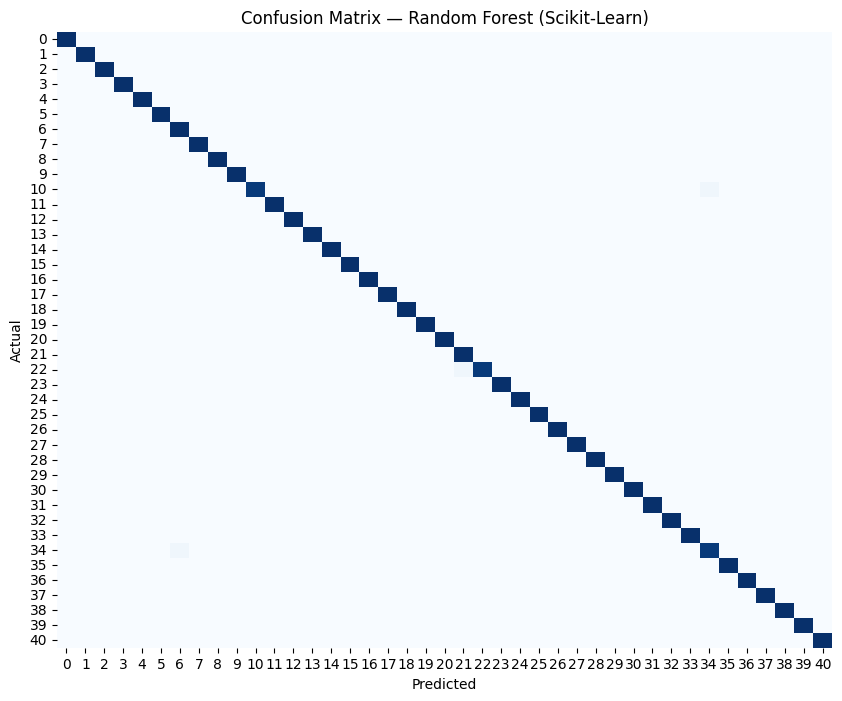

In [18]:
# ============================================================
# STEP 4: METRICS
# ============================================================
acc = np.mean(y_pred == y_true)
print(f"\n Random Forest trained successfully! Accuracy ≈ {acc*100:.2f}%")

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\n Classification Metrics:")
print(report_df[["precision", "recall", "f1-score"]].round(3))

# ROC–AUC
try:
    roc_auc = roc_auc_score(y_test, y_prob, average="macro", multi_class="ovr")
    print(f"\n Macro-average ROC–AUC: {roc_auc:.4f}")
except Exception as e:
    print(f"\n ROC–AUC could not be computed: {e}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix — Random Forest (Scikit-Learn)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
# ============================================================
# STEP 5: SEVERITY + DISEASE INFO RETRIEVAL
# ============================================================
sev["Symptom"] = sev["Symptom"].str.lower().str.strip().str.replace(" ", "_")
sev_map = dict(zip(sev["Symptom"], sev["weight"]))
max_weight = sev["weight"].max()

def get_disease_info_from_csv(disease_name, df_like):
    for col in df_like.columns:
        if col.lower() in ["disease", "prognosis", "disease_name"]:
            key_col = col
            break
    else:
        return None

    df_like[key_col] = df_like[key_col].astype(str).str.lower().str.strip()
    match = difflib.get_close_matches(disease_name.lower(), df_like[key_col].tolist(), n=1, cutoff=0.6)
    if not match:
        return None
    row = df_like[df_like[key_col] == match[0]]
    if not row.empty:
        return [str(x) for x in row.iloc[0, 1:].dropna().tolist()]
    return None

In [20]:
# ============================================================
# STEP 6: PREDICTION FUNCTION
# ============================================================
def build_input(symptoms, severities=None):
    x = np.zeros(len(X.columns))
    matched, total = [], 0
    for s in symptoms:
        s_clean = s.lower().strip().replace(" ", "_")
        if s_clean in X.columns:
            val = severities.get(s_clean, 10) if severities else 10
            val = np.clip(val, 1, 10)
            x[X.columns.get_loc(s_clean)] = val / 10
            matched.append(s_clean)
            total += sev_map.get(s_clean, max_weight * 0.5) * (val / 10)
    return x, matched, total

def get_disease_info(symptoms, severities=None, plot=True):
    x, matched, total = build_input(symptoms, severities)
    proba = forest.predict_proba([x])[0]
    top3_idx = np.argsort(proba)[-3:][::-1]
    top3 = [(class_names[i], float(proba[i])) for i in top3_idx]
    main = top3[0][0]

    sev_conf = (math.log1p(total) / math.log1p(max_weight * len(matched))) * 100 if matched else 0
    sev_conf = min(100, sev_conf)
    results = []
    for d, p in top3:
        model_conf = p * 100
        final_conf = 0.6 * model_conf + 0.4 * sev_conf
        results.append((d, round(final_conf, 2), round(model_conf, 2)))

    results = sorted(results, key=lambda r: r[1], reverse=True)
    main_pred, main_conf, main_model_conf = results[0]

    disease_info = {
        "Top 3 Diseases": results,
        "Predicted Disease": main_pred,
        "Final Confidence (%)": main_conf,
        "Model Confidence (%)": main_model_conf,
        "Severity Confidence (%)": round(sev_conf, 2)
    }

    for label, dataset in [
        ("Description", desc),
        ("Diet", diet),
        ("Medication", med),
        ("Precautions", prec),
        ("Workout", work),
    ]:
        info = get_disease_info_from_csv(main_pred, dataset)
        if info:
            disease_info[label] = info

    if plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.barh([r[0] for r in results][::-1], [r[1] for r in results][::-1])
        plt.title("Top-3 Predicted Diseases")
        plt.xlabel("Confidence (%)")

        plt.subplot(1, 2, 2)
        comps = ["Model", "Severity"]
        vals = [main_model_conf, sev_conf]
        plt.bar(comps, vals)
        plt.title("Confidence Breakdown")
        plt.tight_layout()
        plt.show(block=False)

    return disease_info


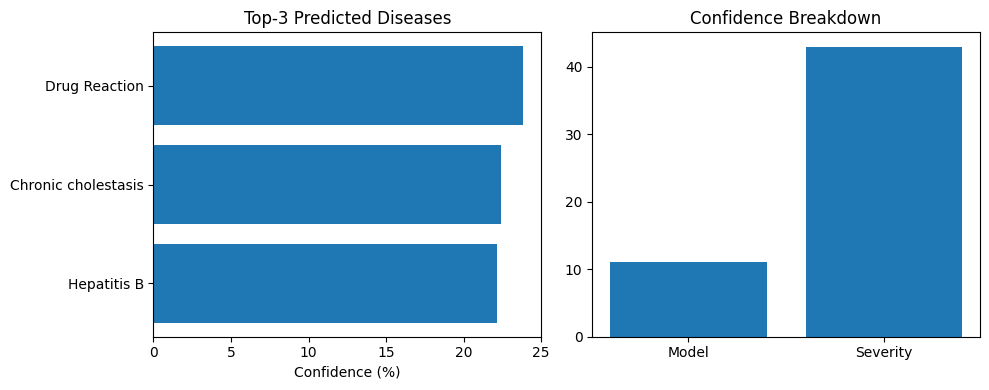


🧾 Final Disease Report:

Top 3 Diseases: [('Drug Reaction', 23.82, 11.06), ('Chronic cholestasis', 22.39, 8.68), ('Hepatitis B', 22.15, 8.29)]

Predicted Disease: Drug Reaction

Final Confidence (%): 23.82

Model Confidence (%): 11.06

Severity Confidence (%): 42.95

Description: ['Drug Reaction occurs when the body reacts adversely to a medication.']

Diet: ["['Antihistamine Diet', 'Omega-3-rich foods', 'Vitamin C-rich foods', 'Quercetin-rich foods', 'Probiotics']"]

Medication: ["['Antihistamines', 'Epinephrine', 'Corticosteroids', 'Antibiotics', 'Antifungal Cream']"]

Precautions: ['drug reaction', 'stop irritation', 'consult nearest hospital', 'stop taking drug', 'follow up']

Workout: ['40', 'drug reaction', 'Discontinue offending medication']

 Execution completed successfully!


In [21]:
# ============================================================
# STEP 7: TEST
# ============================================================
if __name__ == "__main__":
    symptoms = ["itching", "skin_rash"]
    severities = {"itching": 7, "skin_rash": 5}
    result = get_disease_info(symptoms, severities)
    print("\n🧾 Final Disease Report:\n")
    for k, v in result.items():
        print(f"{k}: {v}\n")
    print(" Execution completed successfully!")

In [22]:
# ============================================================
#  AI DOCTOR — RBF Kernel SVM + Full Disease Info + Metrics (Final Stable Version)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)
import seaborn as sns

In [23]:
# ============================================================
# 1️ Load All CSV Files
# ============================================================
df_main = pd.read_csv("Training_like_AI_Doctor.csv")
df_desc = pd.read_csv("description.csv")
df_meds = pd.read_csv("medications.csv")
df_diet = pd.read_csv("diets.csv")
df_prec = pd.read_csv("precautions_df.csv")
df_work = pd.read_csv("workout_df.csv")


In [24]:
# ============================================================
# 2️ Prepare Data
# ============================================================
label_col = "prognosis"
feature_cols = [c for c in df_main.columns if c != label_col]
X = df_main[feature_cols].values.astype(float)
y = df_main[label_col].astype(str).values  # 1D string labels (fixed)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
# ============================================================
# 3️ Build and Train RBF Kernel SVM (Optimized)
# ============================================================
# This version skips long GridSearchCV and uses tuned hyperparameters directly
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42)
)

model.fit(X_train, y_train)
print(" Model training completed successfully!")

 Model training completed successfully!



 Test Accuracy: 99.70%

 Classification Report:
                                         precision  recall  f1-score
(vertigo) Paroymsal  Positional Vertigo      1.000   1.000     1.000
AIDS                                         1.000   1.000     1.000
Acne                                         1.000   1.000     1.000
Alcoholic hepatitis                          1.000   1.000     1.000
Allergy                                      1.000   1.000     1.000
Arthritis                                    1.000   1.000     1.000
Bronchial Asthma                             0.960   1.000     0.980
Cervical spondylosis                         1.000   1.000     1.000
Chicken pox                                  1.000   1.000     1.000
Chronic cholestasis                          1.000   1.000     1.000
Common Cold                                  1.000   0.958     0.979
Dengue                                       1.000   1.000     1.000
Diabetes                                     1.000   1

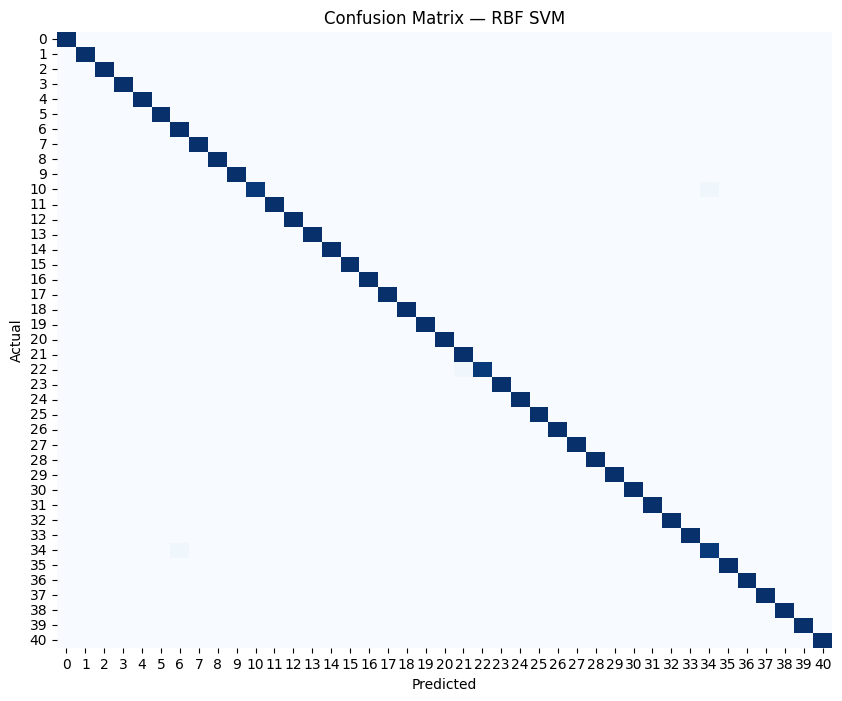

In [26]:
# ============================================================
# 4️ Evaluate Model (Accuracy, Precision, Recall, F1, ROC–AUC)
# ============================================================
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

accuracy = model.score(X_test, y_test)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

try:
    roc_auc = roc_auc_score(pd.get_dummies(y_test), y_prob, average='macro', multi_class='ovr')
except Exception:
    roc_auc = None

print(f"\n Test Accuracy: {accuracy*100:.2f}%")
print("\n Classification Report:")
print(report_df[["precision", "recall", "f1-score"]].round(3))
if roc_auc:
    print(f"\n Macro-average ROC–AUC: {roc_auc:.4f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix — RBF SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
# ============================================================
# 5️ Function to Fetch Disease Details (robust to column names)
# ============================================================
def get_disease_details(disease_name):
    d = disease_name.strip().lower()
    details = {}

    def extract(df):
        # find the disease column automatically (case-insensitive)
        disease_cols = [c for c in df.columns if c.strip().lower() == "disease"]
        if not disease_cols:
            return []
        col = disease_cols[0]
        row = df[df[col].astype(str).str.lower().str.strip() == d]
        if row.empty:
            return []
        return [
            str(x)
            for x in row.drop(columns=col).values.flatten()
            if str(x).strip() and str(x).lower() != "nan"
        ]

    # Description
    try:
        desc_col = [c for c in df_desc.columns if c.strip().lower() == "disease"]
        if desc_col:
            desc_row = df_desc[df_desc[desc_col[0]].astype(str).str.lower().str.strip() == d]
            details["Description"] = (
                desc_row["Description"].iloc[0]
                if not desc_row.empty
                else "No description available."
            )
        else:
            details["Description"] = "No description available."
    except Exception:
        details["Description"] = "No description available."

    # Other details
    details["Medications"] = extract(df_meds) or ["No specific medications."]
    details["Diet"] = extract(df_diet) or ["No specific diet."]
    details["Precautions"] = extract(df_prec) or ["No specific precautions."]
    details["Workout"] = extract(df_work) or ["No workout details."]
    return details


In [28]:
# ============================================================
# 6️ Prediction with Confidences (Top 3)
# ============================================================
def build_feature(symptom_to_severity_1_10):
    x = np.zeros(len(feature_cols))
    for i, name in enumerate(feature_cols):
        if name in symptom_to_severity_1_10:
            s = min(10.0, max(1.0, float(symptom_to_severity_1_10[name])))
            x[i] = s / 10.0
    return x.reshape(1, -1)

def predict_with_confidences(symptom_to_severity_1_10):
    x = build_feature(symptom_to_severity_1_10)
    probs = model.predict_proba(x)[0]
    top3_idx = np.argsort(probs)[-3:][::-1]
    severity_conf = np.mean(list(symptom_to_severity_1_10.values())) / 10.0

    results = []
    for i in top3_idx:
        disease = model.classes_[i]
        model_conf = probs[i]
        final_conf = 0.6 * model_conf + 0.4 * severity_conf
        results.append({
            "Disease": disease,
            "Model Confidence": round(model_conf, 4),
            "Severity Confidence": round(severity_conf, 4),
            "Final Confidence": round(final_conf, 4),
            "Details": get_disease_details(disease)
        })
    best = max(results, key=lambda r: r["Final Confidence"])
    return results, best



In [29]:
# ============================================================
# 7️ Example Prediction
# ============================================================
example_input = {
    "itching": 6,
    "skin_rash": 7,
    "nodal_skin_eruptions": 4,
    "dischromic__patches": 5
}

top3_results, final_choice = predict_with_confidences(example_input)

print("\n Top 3 Predicted Diseases:")
for r in top3_results:
    print(f"{r['Disease']:25} | Final Conf: {r['Final Confidence']} | Model: {r['Model Confidence']} | Severity: {r['Severity Confidence']}")

print(f"\n Final Predicted Disease: {final_choice['Disease']}")


 Top 3 Predicted Diseases:
Fungal infection          | Final Conf: 0.5294 | Model: 0.5157 | Severity: 0.55
Chicken pox               | Final Conf: 0.2638 | Model: 0.073 | Severity: 0.55
Dengue                    | Final Conf: 0.2448 | Model: 0.0413 | Severity: 0.55

 Final Predicted Disease: Fungal infection


In [30]:
# ============================================================
# 8️ Disease Information
# ============================================================
info = final_choice["Details"]
print("\n Disease Details:\n")
print(" Description:", info["Description"])
print("\n Medications:", ", ".join(info["Medications"]))
print("\n Diet Plan:", ", ".join(info["Diet"]))
print("\n Precautions:", ", ".join(info["Precautions"]))
print("\n Workout Advice:", ", ".join(info["Workout"]))


 Disease Details:

 Description: Fungal infection is a common skin condition caused by fungi.

 Medications: ['Antifungal Cream', 'Fluconazole', 'Terbinafine', 'Clotrimazole', 'Ketoconazole']

 Diet Plan: ['Antifungal Diet', 'Probiotics', 'Garlic', 'Coconut oil', 'Turmeric']

 Precautions: 27, bath twice, use detol or neem in bathing water, keep infected area dry, use clean cloths

 Workout Advice: 0, 0, Avoid sugary foods, 1, 1, Consume probiotics, 2, 2, Increase intake of garlic, 3, 3, Include yogurt in diet, 4, 4, Limit processed foods, 5, 5, Stay hydrated, 6, 6, Consume green tea, 7, 7, Eat foods rich in zinc, 8, 8, Include turmeric in diet, 9, 9, Eat fruits and vegetables


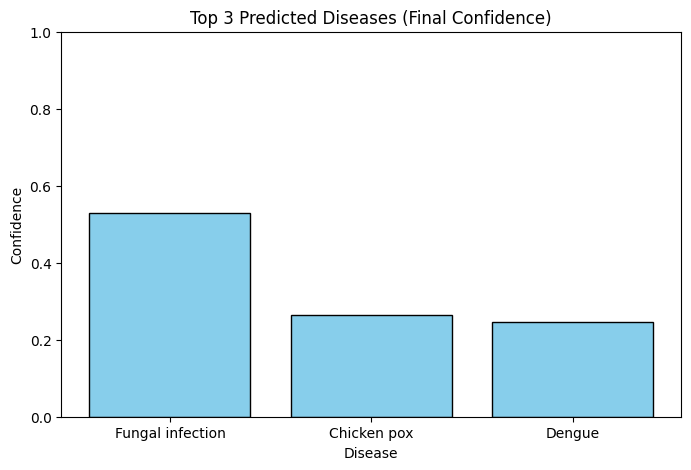

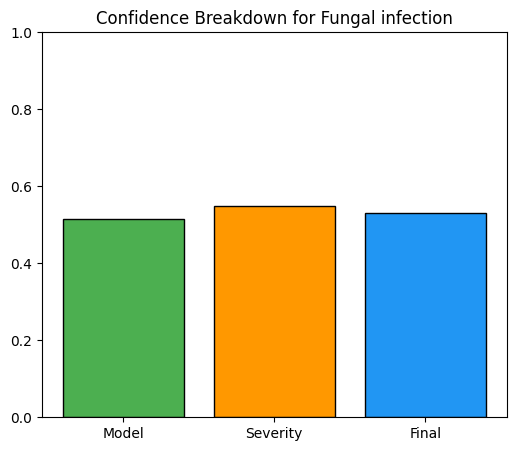

In [31]:
# ============================================================
# 9️ Graphs — Top 3 & Confidence Breakdown
# ============================================================
plt.figure(figsize=(8,5))
plt.bar(
    [r["Disease"] for r in top3_results],
    [r["Final Confidence"] for r in top3_results],
    color="skyblue", edgecolor="black"
)
plt.title("Top 3 Predicted Diseases (Final Confidence)")
plt.xlabel("Disease")
plt.ylabel("Confidence")
plt.ylim(0, 1)
plt.show()

labels = ["Model", "Severity", "Final"]
values = [
    final_choice["Model Confidence"],
    final_choice["Severity Confidence"],
    final_choice["Final Confidence"]
]

plt.figure(figsize=(6,5))
plt.bar(labels, values, color=["#4caf50","#ff9800","#2196f3"], edgecolor="black")
plt.title(f"Confidence Breakdown for {final_choice['Disease']}")
plt.ylim(0, 1)
plt.show()

In [32]:
import joblib
import os

# Create directory for saving models
os.makedirs('saved_models', exist_ok=True)

# Save the complete pipeline (includes scaler + model)
joblib.dump(model, 'saved_models/ai_doctor_pipeline.pkl')
print(" Complete pipeline saved: saved_models/ai_doctor_pipeline.pkl")

# Extract and save scaler from pipeline
scaler = model.named_steps['standardscaler']
joblib.dump(scaler, 'saved_models/scaler.pkl')
print(" Scaler saved: saved_models/scaler.pkl")

# Extract and save SVM model from pipeline
svm_model = model.named_steps['svc']
joblib.dump(svm_model, 'saved_models/svm_model.pkl')
print(" SVM model saved: saved_models/svm_model.pkl")

# Save metadata (feature names and classes)
model_metadata = {
    'feature_names': feature_cols,
    'classes': model.classes_.tolist(),
    'n_features': len(feature_cols)
}
joblib.dump(model_metadata, 'saved_models/model_metadata.pkl')
print(" Metadata saved: saved_models/model_metadata.pkl")

print("\n All models saved successfully in 'saved_models' directory!")

 Complete pipeline saved: saved_models/ai_doctor_pipeline.pkl
 Scaler saved: saved_models/scaler.pkl
 SVM model saved: saved_models/svm_model.pkl
 Metadata saved: saved_models/model_metadata.pkl

 All models saved successfully in 'saved_models' directory!


In [33]:
import joblib
import os

# Create directory for saving models
os.makedirs('saved_models', exist_ok=True)

# Save the trained Random Forest model
joblib.dump(forest, 'saved_models/ai_doctor_random_forest.pkl')
print(" Random Forest model saved: saved_models/ai_doctor_random_forest.pkl")

# Save metadata (feature names and classes)
model_metadata = {
    'feature_names': feature_cols,          #  use stored column names here
    'classes': class_names.tolist(),
    'n_features': len(feature_cols)
}
joblib.dump(model_metadata, 'saved_models/rf_model_metadata.pkl')
print(" Metadata saved: saved_models/rf_model_metadata.pkl")

print("\n All Random Forest assets saved successfully in 'saved_models' directory!")


 Random Forest model saved: saved_models/ai_doctor_random_forest.pkl
 Metadata saved: saved_models/rf_model_metadata.pkl

 All Random Forest assets saved successfully in 'saved_models' directory!
